In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import os

import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd

2024-02-27 19:02:22.613035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Importazione file dataset e creazione di train, test e validation set.
Le immagini vengono normalizzate.

In [2]:
x = np.load("/home/gianluca/Downloads/pneumonia_images.npy")
y = np.load("/home/gianluca/Downloads/pneumonia_labels.npy")

#creazione dei vari dataset
seed = 42
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

#creazione validation set e train set
x_valid_images = train_images[500:]/255.
x_valid_labels = train_labels[500:]
x_train_images = train_images[:500]/255.
x_train_labels = train_labels[:500]

#normalizzazione anche del test set
test_images = test_images/255.

Si può osservare come i dati del dataset non presentano errori o immagini compromesse, inoltre si osserva che le immagini possiedono un solo canale.

errori nelle label:  0
foto compromesse:  0
(28, 28)


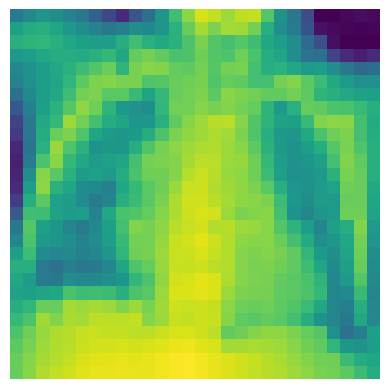

In [34]:
#semplice verifica se ci siano dati mancanti o valori differenti da 0 e 1 per le label
len_y = len(y)
len_image = len(x[0])
count_y = 0
count_x = 0
for i in range(len_y-1):
    if y[i] != 0 and y[i] != 1:
        count_y += 1
    if len(x[i]) != len_image:
        count_x += 1
print("errori nelle label: ",count_y)
print("foto compromesse: ",count_x)

print(x[0].shape)

plt.imshow(x[0])
plt.axis('off')
plt.show()

In [4]:
#verifica sul numero di elementi per classe
lab_one = 0
lab_zero = 0
for i in range(len_y-1):
    if y[i] == 0:
        lab_zero += 1
    else:
        lab_one += 1

print("classe uno ha: ", lab_one," elementi")
print("classe zero ha: ", lab_zero," elementi")

classe uno ha:  3882  elementi
classe zero ha:  1349  elementi


In [5]:
#funzioni utili

def printResults(history):
  pd.DataFrame(history.history).plot(figsize=(5, 3))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()

# FNN
Si inizia ad affrontare il problema con le reti neurali feedforward. Successivamente si passa alle reti cnn. 
Le reti cnn hanno delle prestazioni migliori rispetto alle fnn quando si parla di immagini, però è interessante vedere per il task in questione quanto le cnn si comportino meglio rispetto alle fnn, o se le fnn in problemi di binary image classification si comportano bene. 
La fnn che si ottiene in questa porzione di notebook ha svolto il ruolo principale di indicazione guida sul comportamento delle cnn. Ovvero la famiglia di modelli scelta per affrontare il problema di binary image classification proposto è la famiglia delle reti neurali convoluzionali. Quindi la rete fnn che si ottiene è solo per osservare se il lavoro svolto con le cnn sia corretto.

Si esplorano più reti fnn in base al numero di layer e numero di unità per layer.
Le reti avranno in comune gli ultimi 3 livelli densi da 32, 16 e 1 livello, mentre variano i primi livelli.

In [6]:
#definisco un modello per testare dei valori differenti per numero di unità e numero layer
#i layer finali sono fissi con 32 unità e 16 unità, variano gli upper layer, i primi livelli
def build_model(n_layers, units_array):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    
    for i in range(n_layers - 1):
        model.add(keras.layers.Dense(units_array[i], activation='relu'))

    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

#funzione utile per addestrare un modello creato con la funziona sopra
#l'addestramento viene sempre arrestato da early stopping, quindi il numero di epoche indicato è 
#sufficiente per l'addestramento completo
def train_model(model):
    model.fit(x_train_images, x_train_labels, epochs=30,
                    verbose=0,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])

In [7]:
#4 è il numero massimo di upper layer
#il vettore numero di unità è [512,256,128,64]
#se si volessero modificare i valori da testare: max_layer = len(n_units)
n_units = [512,256,128,64]
max_layer = 4

loss_results = []
accuracy_results = []

model_list = []

for i in range(max_layer-1):
    if i == 0:
        cur_model = build_model(max_layer,n_units)
    else:
        cur_model = build_model(max_layer-i,n_units[i:])

    model_list.append(cur_model)
    print("risultati su test set modello:")
    print("layers: ",max_layer-i)
    print("units: ",n_units[i:])
    
    train_model(cur_model)
    cur_loss, cur_acc = cur_model.evaluate(test_images, test_labels)
    
    print("loss: ",cur_loss)
    print("accuracy: ",cur_acc)
    print("\n")
    
    loss_results.append(cur_loss)
    accuracy_results.append(cur_acc)
    

risultati su test set modello:
layers:  4
units:  [512, 256, 128, 64]


2024-02-27 19:02:23.968188: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


17/17 [==============================] - 1s 28ms/step - loss: 0.2250 - accuracy: 0.8969
loss:  0.22498075664043427
accuracy:  0.8969465494155884


risultati su test set modello:
layers:  3
units:  [256, 128, 64]
17/17 [==============================] - 0s 4ms/step - loss: 0.1480 - accuracy: 0.9466
loss:  0.14804808795452118
accuracy:  0.9465649127960205


risultati su test set modello:
layers:  2
units:  [128, 64]
17/17 [==============================] - 0s 20ms/step - loss: 0.1452 - accuracy: 0.9408
loss:  0.14517514407634735
accuracy:  0.9408397078514099




In [8]:
#prendo il modello con miglior accuracy tra quelli provati
n_units = [512,256,128,64]
max_layer = 4

index = np.argmax(accuracy_results)

model = model_list[index]

model.summary()

model.evaluate(test_images, test_labels)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 238,529
Trainable params: 238,529
Non-tr

[0.14804808795452118, 0.9465649127960205]

Questo modello è stato utilizzato solo come linea guida per il comportamento dei modelli basati su reti convoluzionali.
Inoltre, il training dei tre modelli fnn viene terminato dall'early stopping. Quindi i valori utilizzati come linea guida sono gli stessi utilizzati per scegliere la migliore rete neurale feedforward.

# CNN

In [9]:
x_tensor_train = x_train_images.reshape(-1,28,28,1)
x_tensor_valid = x_valid_images.reshape(-1,28,28,1)
test_tensor = test_images.reshape(-1,28,28,1)

Si utilizza come prima rete cnn la rete LeNet, dove al posto delle funzioni di attivazioni sono state sostituite le sigmoid con le relu. Questa rete si utilizza come base per ottenere le successive reti cnn. Inoltre questa rete viene utilizzata anche per testare la miglior loss function per il task in questione.

Come per le reti precedenti, si aggiunge un livello finale per la binary classification.
Inoltre si testa quale sia la miglior operazione del livello di pooling tra max pooling e average pooling. 

In [10]:
def build_lenet(pool_type, loss):
    
    lenet = tf.keras.models.Sequential()
    lenet.add(keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
            
    match pool_type:
        case 1:
              lenet.add(keras.layers.AvgPool2D(pool_size=2, strides=2))
        case 2:
              lenet.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
            
    lenet.add(keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu'))

    match pool_type:
        case 1:
              lenet.add(keras.layers.AvgPool2D(pool_size=2, strides=2))
        case 2:
              lenet.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
            
    lenet.add(keras.layers.Flatten())
    lenet.add(keras.layers.Dense(120, activation='relu'))
    lenet.add(keras.layers.Dense(84, activation='relu'))
    lenet.add(keras.layers.Dense(10, activation='relu'))
    lenet.add(keras.layers.Dense(1, activation='sigmoid'))

    lenet.compile(loss=loss,
              optimizer="adam",
              metrics=["accuracy"])
    return lenet

In [35]:
lenet1 = build_lenet(1,"binary_crossentropy")
lenet2 = build_lenet(2,"binary_crossentropy")

lenet1.fit(x_tensor_train, x_train_labels, epochs=20, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])
lenet2.fit(x_tensor_train, x_train_labels, epochs=20, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])

lenet1.evaluate(test_tensor, test_labels)
lenet2.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 9ms/step - loss: 0.1501 - accuracy: 0.9370


[0.1500503569841385, 0.9370229244232178]

In generale le due operazioni di pooling non hanno prestazioni molto differenti per quanto riguarda l'accuracy sul test set. La loss del test set in più iterazioni sembra risultare più bassa (di poco) con il max pooling.
Si sceglie dunque il max pooling come livello di pooling dei successivi modelli.

Per la scelta della loss function vengono testate 3 loss function:loss1 = "binary_crossentropy", "mean_squared_error" e "binary_focal_crossentropy". Vengono testate usando LeNet. 

In [12]:
loss1 = "binary_crossentropy"
loss2 = "mean_squared_error"
loss3 = "binary_focal_crossentropy"

lenet1 = build_lenet(2,loss1)
lenet2 = build_lenet(2,loss2)
lenet3 = build_lenet(2,loss3)

lenet1.fit(x_tensor_train, x_train_labels, epochs=50, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7)])
lenet2.fit(x_tensor_train, x_train_labels, epochs=50, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7)])
lenet3.fit(x_tensor_train, x_train_labels, epochs=50, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7)])

lenet1.evaluate(test_tensor, test_labels)
lenet2.evaluate(test_tensor, test_labels)
lenet3.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 14ms/step - loss: 0.0436 - accuracy: 0.9485


[0.04363809898495674, 0.9484732747077942]

Se si considera la accuracy sul test set, la miglior loss function è la binary cross entropy. Già da questo primo test si può notare come, considerando il valore di loss per il test set, la miglior loss function sia la binary focal cross entropy.
Anche con la rete cnn2 definita più avanti, sono stati ottenuti gli stessi risultati.

In [13]:
lenet1 = build_lenet(2,loss1)
lenet2 = build_lenet(2,loss2)
lenet3 = build_lenet(2,loss3)

lenet1.fit(x_tensor_train, x_train_labels, epochs=50, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=7)])
lenet2.fit(x_tensor_train, x_train_labels, epochs=50, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=7)])
lenet3.fit(x_tensor_train, x_train_labels, epochs=50, verbose=0,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=7)])

lenet1.evaluate(test_tensor, test_labels)
lenet2.evaluate(test_tensor, test_labels)
lenet3.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 5ms/step - loss: 0.0311 - accuracy: 0.9561


[0.031137382611632347, 0.9561068415641785]

Poichè con i seguenti modelli si da più attenzione al valore di accuracy, si sceglie di utilizzare come loss function la binary cross entropy.

Nonostante sia stato scelto di concentrarsi sulla validation accuracy, i risultati per la metrica di loss sono comunque sufficienti per giustificare tale scelta.


Si estende LeNet con altri 3 livelli convoluzionali e due livelli di max pooling. Inoltre tutti i livelli convoluzionali applicano padding in modo tale che dimensione di input = dimensione output.

In [14]:
cnn1 = tf.keras.models.Sequential([
            #input 28x28
            tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)),
            #input 28x28
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            #input 14x14
            tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'),
            #input 14x14
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            #input 7x7
            tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu', padding='same'),
            #input 7x7
            tf.keras.layers.MaxPool2D(pool_size=2, strides=1),
            #input 6x6
            tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', padding='same'),
            #input 6x6
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            #input 3x3
            tf.keras.layers.Conv2D(filters=80, kernel_size=3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')])

cnn1.compile(loss="binary_focal_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

cnn1.fit(x_tensor_train, x_train_labels, epochs=100,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)])

Epoch 1/100
16/16 [==============================] - 4s 204ms/step - loss: 0.1552 - accuracy: 0.7160 - val_loss: 0.1451 - val_accuracy: 0.7407
Epoch 2/100
16/16 [==============================] - 3s 191ms/step - loss: 0.1468 - accuracy: 0.7240 - val_loss: 0.1374 - val_accuracy: 0.7407
Epoch 3/100
16/16 [==============================] - 3s 181ms/step - loss: 0.1316 - accuracy: 0.7240 - val_loss: 0.0985 - val_accuracy: 0.7407
Epoch 4/100
16/16 [==============================] - 3s 183ms/step - loss: 0.1021 - accuracy: 0.8120 - val_loss: 0.1025 - val_accuracy: 0.8258
Epoch 5/100
16/16 [==============================] - 3s 179ms/step - loss: 0.0908 - accuracy: 0.8360 - val_loss: 0.0710 - val_accuracy: 0.9009
Epoch 6/100
16/16 [==============================] - 3s 187ms/step - loss: 0.0765 - accuracy: 0.8640 - val_loss: 0.0638 - val_accuracy: 0.8973
Epoch 7/100
16/16 [==============================] - 3s 217ms/step - loss: 0.0712 - accuracy: 0.8980 - val_loss: 0.0567 - val_accuracy: 0.9190

In [15]:
cnn1.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.9523


[0.10708975791931152, 0.9522900581359863]

L'accuracy di cnn1 in fase di training è molto alta, in alcune epoche tocca anche il valore 0.99, mentre nel testing l'accuracy scende allo 0.95. Anche la loss aumenta tra training e testing, quindi si cerca di diminuire l'overfitting applicando livelli di dropout.
Si aumentano il numero di epoche e la patience poichè i livelli di dropout rallentano il training.
Sono stati testati i seguenti valori di dropout:0.10, 0.15, 0.20, 0.25, 0.30. I migliori risultati sono stati ottenuti con dropout 0.25.

In [16]:
def create_cnn2_model():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
    #input 28x28
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 14x14
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'))
    #input 14x14
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 7x7
    model.add(tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu', padding='same'))
    #input 7x7
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=1))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 6x6
    model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', padding='same'))
    #input 6x6
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 3x3
    model.add(tf.keras.layers.Conv2D(filters=80, kernel_size=3, activation='relu'))
            
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dense(84, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
    return model

In [26]:
cnn2 = create_cnn2_model()

cnn2.fit(x_tensor_train, x_train_labels, epochs=200,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=35)])

Epoch 1/200
16/16 [==============================] - 4s 232ms/step - loss: 0.6440 - accuracy: 0.7100 - val_loss: 0.6297 - val_accuracy: 0.7407
Epoch 2/200
16/16 [==============================] - 4s 234ms/step - loss: 0.5919 - accuracy: 0.7240 - val_loss: 0.6155 - val_accuracy: 0.7407
Epoch 3/200
16/16 [==============================] - 4s 230ms/step - loss: 0.5904 - accuracy: 0.7240 - val_loss: 0.5889 - val_accuracy: 0.7407
Epoch 4/200
16/16 [==============================] - 4s 246ms/step - loss: 0.5883 - accuracy: 0.7240 - val_loss: 0.6057 - val_accuracy: 0.7407
Epoch 5/200
16/16 [==============================] - 4s 253ms/step - loss: 0.5867 - accuracy: 0.7240 - val_loss: 0.6160 - val_accuracy: 0.7407
Epoch 6/200
16/16 [==============================] - 4s 232ms/step - loss: 0.5770 - accuracy: 0.7240 - val_loss: 0.5782 - val_accuracy: 0.7407
Epoch 7/200
16/16 [==============================] - 4s 224ms/step - loss: 0.5563 - accuracy: 0.7240 - val_loss: 0.5417 - val_accuracy: 0.7407

In [27]:
cnn2.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 5ms/step - loss: 0.0816 - accuracy: 0.9714


[0.08162851631641388, 0.9713740348815918]

Come detto sopra, sono state testate le 3 loss function anche con la rete cnn2 e i risultati migliori sono i seguenti. 

Binary cross entropy restituisce come migliori valori:
loss: 0.0328 - accuracy: 0.9752.

Mean squared error loss restituisce i seguenti valori:
loss: 0.0329 - accuracy: 0.9523.

Binary focal cross entropy restituisce i seguenti valori:
loss: 0.0398 - accuracy: 0.9523.

(Non vi sono celle di codice riguardo questo controllo perchè occorre cambiare la loss function del modello cnn2. Inoltre gli output del training di cnn2 con le differenti loss function non sono stati riportati nel notebook per alleggerire il carico visivo di questo file)

Ultima modifica che si effettua a cnn2 è aumentare il numero di livelli dense e il numero di unità di tali livelli.

In [20]:
def create_cnn3_model():
    model = tf.keras.models.Sequential()
    #input 28x28
    model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=(28, 28, 1)))
    #input 28x28
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 14x14
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', padding='same'))
    #input 14x14
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 7x7
    model.add(tf.keras.layers.Conv2D(filters=30, kernel_size=5, activation='relu', padding='same'))
    #input 7x7
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=1))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 6x6
    model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', padding='same'))
    #input 6x6
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Dropout(0.25))
    #input 3x3
    model.add(tf.keras.layers.Conv2D(filters=80, kernel_size=3, activation='relu'))
            
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
    return model

In [28]:
cnn3 = create_cnn3_model()
cnn3.fit(x_tensor_train, x_train_labels, epochs=200,
                    validation_data=(x_tensor_valid, x_valid_labels),
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=35)])

Epoch 1/200
16/16 [==============================] - 5s 240ms/step - loss: 0.6292 - accuracy: 0.7200 - val_loss: 0.5832 - val_accuracy: 0.7407
Epoch 2/200
16/16 [==============================] - 3s 220ms/step - loss: 0.6086 - accuracy: 0.7240 - val_loss: 0.5965 - val_accuracy: 0.7407
Epoch 3/200
16/16 [==============================] - 4s 223ms/step - loss: 0.5870 - accuracy: 0.7240 - val_loss: 0.5674 - val_accuracy: 0.7407
Epoch 4/200
16/16 [==============================] - 3s 213ms/step - loss: 0.5831 - accuracy: 0.7240 - val_loss: 0.5782 - val_accuracy: 0.7407
Epoch 5/200
16/16 [==============================] - 3s 220ms/step - loss: 0.5458 - accuracy: 0.7240 - val_loss: 0.5010 - val_accuracy: 0.7407
Epoch 6/200
16/16 [==============================] - 3s 220ms/step - loss: 0.5153 - accuracy: 0.7240 - val_loss: 0.4253 - val_accuracy: 0.7407
Epoch 7/200
16/16 [==============================] - 3s 217ms/step - loss: 0.4646 - accuracy: 0.7240 - val_loss: 0.3949 - val_accuracy: 0.7407

In [29]:
cnn3.evaluate(test_tensor, test_labels)

17/17 [==============================] - 0s 5ms/step - loss: 0.1172 - accuracy: 0.9676


[0.1171889528632164, 0.9675572514533997]

Aumentare il numero di livelli dense e il numero di unità di tali livelli non sembra aver portato miglioramenti.

Il modello migliore è cnn2. Anche cnn3 ha delle sufficienti prestazioni, tuttavia si sceglie come modello finale la rete neurale cnn2.

In [36]:
cnn2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 6)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 16)        

Interessante è il fatto che la rete cnn2 abbia meno della metà dei parametri addestrabili rispetto alla rete fnn ottenuta ad inizio notebook. Questo dimostra il vantaggio delle reti convoluzionali su task in cui i dati sono immagini. 

Con tale rete si genera una confusion matrix e si misurano i valori di precision e recall.

Nel codice sottostante si è applicata la threshold 0.5 per le predizioni. Dalla documentazione si evince che sia lo stesso valore di threshold che applica la funzione di attivazione sigmoid.

17/17 [==============================] - 0s 10ms/step


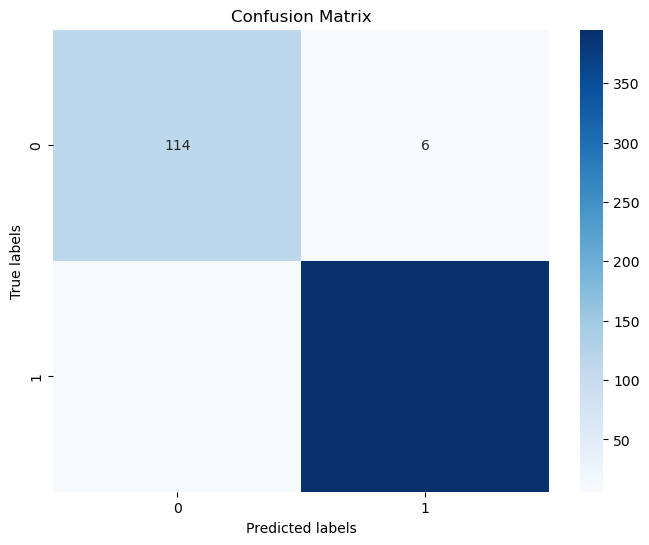

Precision: 0.9850374064837906
Recall: 0.9777227722772277


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

predictions = cnn2.predict(test_tensor)
y_pred = (predictions > 0.5).astype("int32")

cm = confusion_matrix(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

print("Precision:",precision)
print("Recall:",recall)

Nella ricerca dei migliori parametri molti test non sono stati riportati nel notebook. Sono stati testati molti modelli di reti neurali con numero differenti di livelli convoluzionali, in alcuni casi il numero di layer era talmente eccessivo che il modello aveva zero capacità di generalizzazione. Sono stati testati anche differenti dimensioni per i filtri, ovvero valori 3,5,7,11. I miglior valori sono stati 5 e 3. Anche il numero di filtri è stato fatto variare. Dai vari test si è notato che un numero eccessivo (come atteso) comporta overfitting. Inoltre un numero fisso come numero di filtri non è ottimale. La miglior configurazione di numero di filtri sembra essere una configurazione crescente. 

Dalla confusion matrix possiamo osservare come il test sia formato da molti dati della classe 1, di cui quasi la totalità è stata correttamente etichettata. Similmente per i dati della classe 0, che possiede meno dati. La disparità nella presenza delle classi nel test set dipende anche dal fatto che la classe 1 possiede il triplo di dati rispetto alla classe 0.

Il valore alto della accuracy del modello cnn2 e il valore relativamente basso della loss (valori su test set) indicano che il modello implementato è sufficientemente capace di classificare i dati del nostro dataset. Anche i valori di precision e recall sono sufficientemente alti, quindi anche questi testimoniano la capacità sufficiente della rete.


Per valutare i modelli cnn1, cnn2, cnn3 non è stata utilizzata la tecnica di cross validation per il fatto che tale tecnica richiede un tempo eccessivo.
cnn1 richiede circa 4 secondi ad epoca per all'incirca 50 epoche, cnn2 5 secondi ad epoca per 120 epoche e cnn3 4 secondi ad epoca per 180 epoche. Quindi il tempo richiesto per addestrare tali reti è circa 25 minuti per iterazione di addestramento. Applicare la tecnica di cross validation con k fold, ad esempio k=10 come consigliato, comporterebbe un costo di training di oltre 4 ore.
Inoltre il secondo motivo per cui non è stata utilizzata tale tecnica è il fatto che il miglior modello è cnn2, poichè estende cnn1, mentre cnn3 non migliora le prestazioni. 

Durante i vari test è stato cambiata la variabile "seed" ad inizio notebook. Tale variabile condiziona come vengono suddivisi i dati del dataset in train e test set. Quindi indirettamente variava anche il validation set. Tale effetto non è paragonabile all cross validation, assolutamente, però ha fatto variare i risultati dei training.

In [ ]:
"""
#codice per effettuare uno pseudo cross validation
from sklearn.model_selection import KFold

num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True)

#lista per mantenere risultati
cv_scores_cnn2 = []
cv_scores_cnn3 = []

for fold_idx, (train_indices, val_indices) in enumerate(kf.split(train_images)):
    print(f"Fold {fold_idx + 1}/{num_folds}")
    
    #divisione in train e validation
    x_train_fold, x_val_fold = train_images[train_indices], train_images[val_indices]
    y_train_fold, y_val_fold = train_labels[train_indices], train_labels[val_indices]

    x_tensor_train_fold = x_train_fold.reshape(-1,28,28,1)
    x_tensor_valid_fold = x_val_fold.reshape(-1,28,28,1)
    
    cv_cnn2 = create_cnn2_model()
    cv_cnn3 = create_cnn3_model()
    
    cv_cnn2.fit(x_tensor_train_fold, y_train_fold, 
                validation_data=(x_tensor_valid_fold, y_val_fold), 
                epochs=100, 
                callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)],
                batch_size=32, verbose=0)
    cv_cnn3.fit(x_tensor_train_fold, y_train_fold, 
                validation_data=(x_tensor_valid_fold, y_val_fold), 
                epochs=100, 
                callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)],
                batch_size=32, verbose=0)
    
    val_loss2, val_acc2 = cv_cnn2.evaluate(x_tensor_valid_fold, y_val_fold, verbose=0)
    val_loss3, val_acc3 = cv_cnn3.evaluate(x_tensor_valid_fold, y_val_fold, verbose=0)
    cv_scores_cnn2.append(val_acc2)
    cv_scores_cnn3.append(val_acc3)


mean_cv_accuracy_cnn2 = np.mean(cv_scores_cnn2)
mean_cv_accuracy_cnn3 = np.mean(cv_scores_cnn3)

print("Mean Cross-Validation Accuracy for cnn2: ",mean_cv_accuracy_cnn2)
print("Mean Cross-Validation Accuracy for cnn3: ",mean_cv_accuracy_cnn3)
"""